# Document Classification

##### Author: Alex Sherman | alsherman@deloitte.com

Agenda:
- Data Labeling
- Problem Definition and Feasibility
- Evaluation Metrics
- Train Test Split
- Cross Validation
- Nested Cross Validation
- Classification Models 
    - Logistic Regression, Naive Bayes, RandomForestClassifier

In [6]:
import numpy as np
import pandas as pd
from sqlalchemy import create_engine
from collections import defaultdict
from IPython.core.display import display, HTML
from configparser import ConfigParser, ExtendedInterpolation
from IPython.display import Image
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

In [7]:
# configuration for data, acronyms, and gensim paths
config = ConfigParser(interpolation=ExtendedInterpolation())
config.read('../../config.ini')

DB_PATH = config['DATABASES']['PROJECT_DB_PATH']

In [8]:
engine = create_engine(DB_PATH)
df = pd.read_sql("SELECT * FROM Sections", con=engine)
df.head(3)

,section_id,filename,section_name,section_text,criteria,section_length
0,1,southwest-airlines-co_annual_report_1994.docx,FIRST SECTION,© 1994 Southwest Airlines Co. This annual repo...,<function heading at 0x000001D4AA492EA0>,83
1,2,southwest-airlines-co_annual_report_1994.docx,TABLE OF CONTENTS CONSOLIDATED HIGHLIGHTS,(Dollars in thousands except per share amounts...,<function heading at 0x000001D4AA492EA0>,113
2,3,southwest-airlines-co_annual_report_1994.docx,NET INCOME NET INCOME PER SHARE LOW FARES,"Southwest Airlines was built, from the ground ...",<function heading at 0x000001D4AA492EA0>,1553


In [9]:
df['year'] = df['filename'].apply(lambda x: int(x.split('.')[0][-4:]))
df.head(1)

,section_id,filename,section_name,section_text,criteria,section_length,year
0,1,southwest-airlines-co_annual_report_1994.docx,FIRST SECTION,© 1994 Southwest Airlines Co. This annual repo...,<function heading at 0x000001D4AA492EA0>,83,1994


### Data Labeling Exercise

For each scenario, provide a label (1-10) whether the text should be included in the analysis.

##### We are conducting an analysis of fees at Southwest Airlines. Should we include the following paragraph in the analysis (1-10 scale)

"Other operating expenses consist of distribution costs, advertising expenses, personnel expenses, professional fees, and other operating costs, none of which individually exceed 10 percent of Operating expenses."

##### We are conducting an analysis of customer fares at Southwest Airlines. In particular, all fares related to passenger class (First, Business, Coach) are relevant. A functional analyst on your team forwarded a document containing the following paragraph. 

**Should we include the following paragraph in the analysis (1-10 scale with 1=Definitely do not include and 10=Definitely include)**

"AirTran also offers a user-friendly fare structure that features a variety of competitive fares and products. Unlike Southwest, AirTran currently offers a Business Class product. With the exception of Business Class fares, all AirTran fares are nonrefundable, but can be changed prior to departure, subject to payment of a service charge."






**You are a financial analyst tasked to identify and categorize all fee types after the Southwest and AirTran merger. You have been instructued to tag True/False for whether each paragraph discuesses a fee. To complete the task in time you must categorize at least one paragraph every 15 seconds.**

**Read through the following paragraph about fees, once and only once. Answer the question in 15 seconds or less, should we include the following paragraph in the analysis (1-10 scale with 1=Definitely do not include and 10=Definitely include)**

During 2014, AirTran offered a user-friendly fare structure that featured a variety of competitive fares and products. Unlike Southwest, AirTran offered a Business Class product. With the exception of Business Class fares, all AirTran fares were nonrefundable, but could be changed prior to departure. AirTran Business Class fares were refundable and changeable and included additional perks such as priority boarding, oversized seats with additional leg room, bonus frequent flyer credit, no first or second bag fees, and complimentary cocktails onboard. In addition, AirTran’s Business Class product could be purchased separately or through an upgrade of a non-Business Class fare within 24 hours of travel.

**You are a product manager in charge of customer complaints about fees. Your bonus is tied to the % of complaints about fees after the merger (i.e. your bonus will descrease as the discussion about fees increases). We are measuring the baseline now for which to used as a comparison point in the future to determine if the discussion of fees increased.**

**Shold we include the fees discussed in the following paragraph?**

"The majority of the Company’s terminal operations space, as well as 95 aircraft, were under operating  leases  at  December 31, 2015. For aircraft operating leases and for terminal operations leases, expense is  included in Aircraft rentals and in Landing fees and other rentals, respectively, in the Consolidated Statement of Income. Future minimum lease payments under capital leases and noncancelable  operating leases and rentals to be received under subleases with initial or remaining terms in excess of one year at December 31, 2015, were..."

### Data labeling exercise review

In each case, the results may vary due to issue with the instructions, resources, incentives, and data quality

1. Lack of clear, consistent rules to follow will lead to differing opinions for the same data
2. Limited Resources (e.g. time)
    - the paragraph says "**no** first or second bag fees"
3. Incentive (for a specific role) may skew opinion
4. Bad data
    - No, the paragraph is about AirTran


Without valid, trustworthy labels, the remaining steps in the data science process will not lead to business value.

### Problem Definition - Feasibility

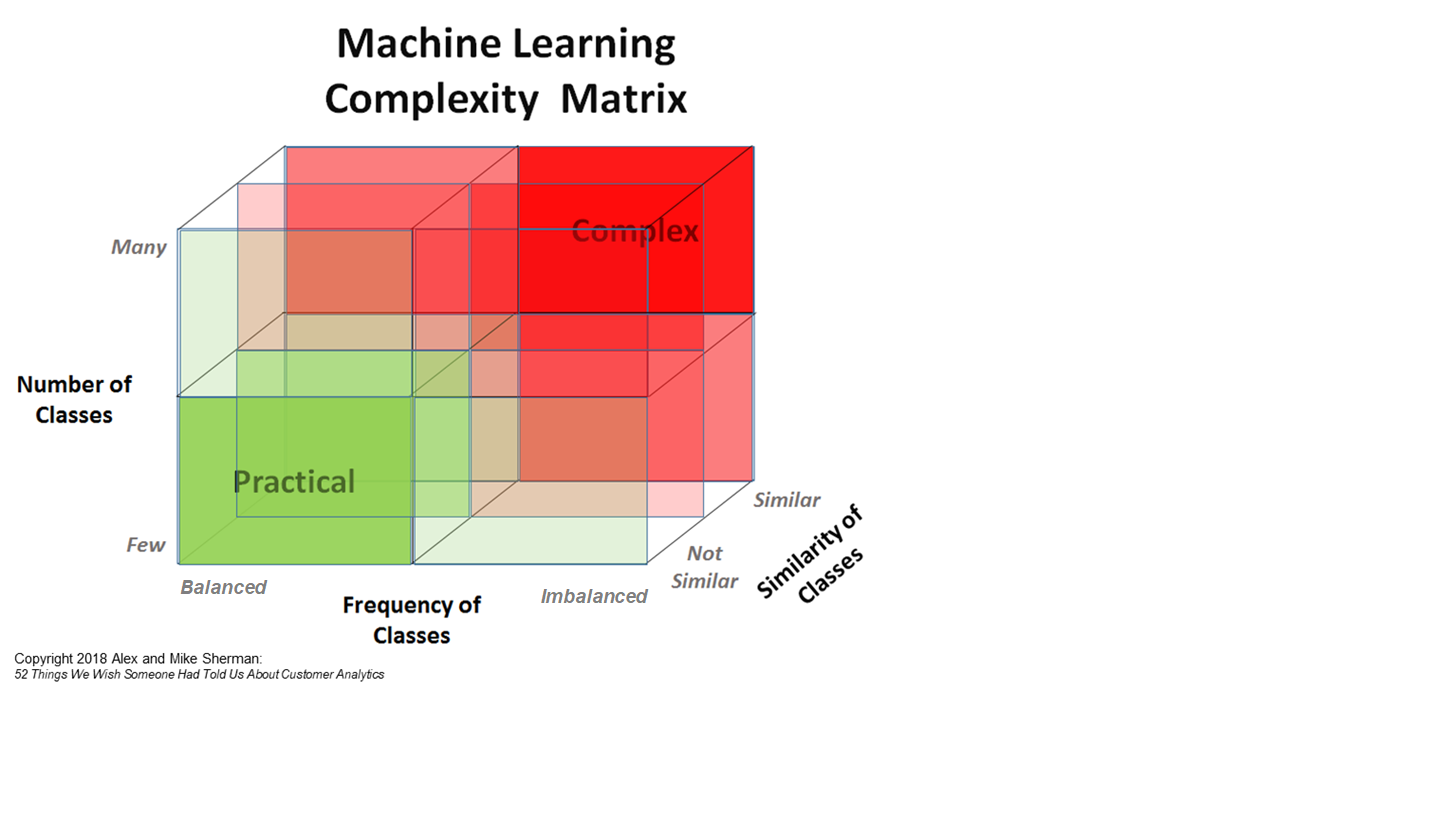

In [115]:
# ML Feasibility Matrix
Image("../../raw_data/images/ml_feasibility.png", width=600)

### Evaluation Metrics

Installation: conda install mlxtend

In [11]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix

In [12]:
mlxtend_url = 'http://rasbt.github.io/mlxtend/user_guide/evaluate/confusion_matrix/'
iframe = '<iframe src={} width=900 height=400></iframe>'.format(mlxtend_url)
HTML(iframe)

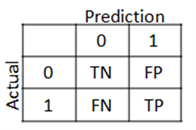

In [118]:
# confusion matrix
Image("../../raw_data/images/confusion_matrix.png", width=200)

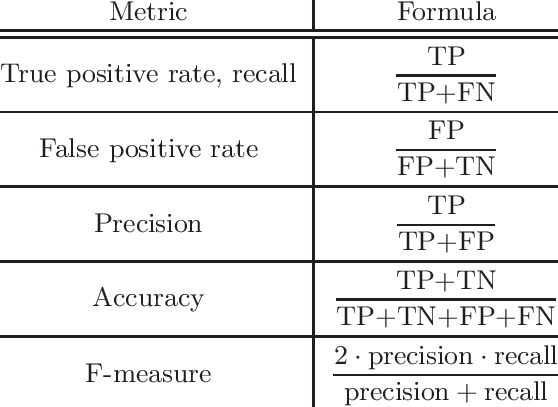

In [119]:
Image("../../raw_data/images/evaluation_metrics.png", width=300)

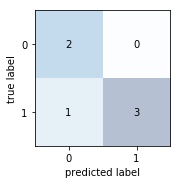

In [120]:
y_true = [1, 0, 1, 1, 0, 1]
y_pred = [0, 0, 1, 1, 0, 1]

cm = confusion_matrix(y_true, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

##### multilabel  confusion matrix

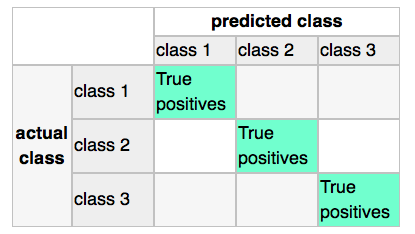

In [121]:
# confusion matrix multiclass
Image("../../raw_data/images/confusion_matrix_multiclass.png", width=300)

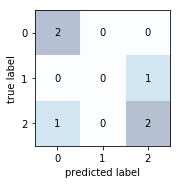

In [13]:
y_true = [2, 0, 2, 2, 0, 1]
y_pred = [0, 0, 2, 2, 0, 2]

cm = confusion_matrix(y_true, y_pred)
fig, ax = plot_confusion_matrix(conf_mat=cm)
plt.show()

### F1 score


The F1 score can be interpreted as a weighted average of the precision and
recall, where an F1 score reaches its best value at 1 and worst score at 0.
The relative contribution of precision and recall to the F1 score are
equal. The formula for the F1 score is::

    F1 = 2 * (precision * recall) / (precision + recall)
    
    
``'binary'``:
    Only report results for the class specified by ``pos_label``.
    This is applicable only if targets (``y_{true,pred}``) are binary.
   
``'micro'``:
    Calculate metrics globally by counting the total true positives,
    false negatives and false positives.
    
``'macro'``:
    Calculate metrics for each label, and find their unweighted
    mean.  This does not take label imbalance into account.
    
``'weighted'``:
    Calculate metrics for each label, and find their average, weighted
    by support (the number of true instances for each label). This
    alters 'macro' to account for label imbalance; it can result in an
    F-score that is not between precision and recall.
    
``'samples'``:
    Calculate metrics for each instance, and find their average (only
    meaningful for multilabel classification where this differs from
    :func:`accuracy_score`)
    

SOURCE:
- [Sklearn Documentation - F1 Score](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html)
- [Micro Average vs Macro average Performance in a Multiclass classification setting](https://datascience.stackexchange.com/questions/15989/micro-average-vs-macro-average-performance-in-a-multiclass-classification-settin)

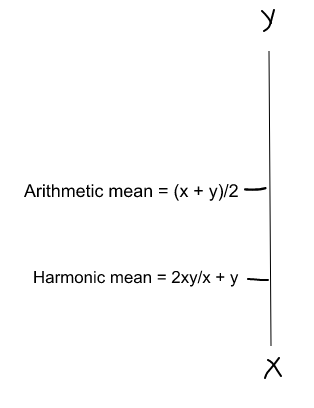

In [14]:
# The F1 score is the harmonic mean of precision and recall

##### Harmonic Mean
# Harmonic mean is kind of an average when x and y are equal. 
# But when x and y are different, then it’s closer to the smaller number as compared to the larger number.

Image("../../raw_data/images/harmonic_mean.png", width=250)



In [18]:
from sklearn.metrics import f1_score

In [19]:
average_options = ['macro','micro','weighted']

In [20]:
# multiclass classification
y_true =  [0,1,1]
y_pred = [[0,0,1]]   # two mistakes in class 1

for pred in y_pred:
    print(pred)
    for option in average_options:
        print('{}: {:.3f}'.format(option, f1_score(y_true, pred, average=option)))
    print()

[0, 0, 1]
macro: 0.667
micro: 0.667
weighted: 0.667



In [21]:
# multiclass classification
y_true =  [0,1,1,2,2,2]

y_pred = [[0,1,1,2,2,2]    # perfect prediction
         ,[0,1,1,2,2,1]    # one mistake in class 2
         ,[0,1,2,2,2,2]    # one mistake in class 1
         ,[1,1,1,2,2,2]    # one mistake in class 0
         ,[0,1,1,1,1,2]    # two mistakes in class 2
         ,[0,2,2,2,2,2]]   # two mistakes in class 1

for pred in y_pred:
    print(pred)
    for option in average_options:
        print('{}: {:.3f}'.format(option, f1_score(y_true, pred, average=option)))
    print()

[0, 1, 1, 2, 2, 2]
macro: 1.000
micro: 1.000
weighted: 1.000

[0, 1, 1, 2, 2, 1]
macro: 0.867
micro: 0.833
weighted: 0.833

[0, 1, 2, 2, 2, 2]
macro: 0.841
micro: 0.833
weighted: 0.817

[1, 1, 1, 2, 2, 2]
macro: 0.600
micro: 0.833
weighted: 0.767

[0, 1, 1, 1, 1, 2]
macro: 0.722
micro: 0.667
weighted: 0.639

[0, 2, 2, 2, 2, 2]
macro: 0.583
micro: 0.667
weighted: 0.542



C:\Users\alsherman\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


### Classification Report

In [127]:
from sklearn.metrics import classification_report

y_true = [0, 1, 2, 2, 2]
y_pred = [0, 0, 2, 2, 1]
target_names = ['class 0', 'class 1', 'class 2']
print(classification_report(y_true, y_pred, target_names=target_names))

             precision    recall  f1-score   support

    class 0       0.50      1.00      0.67         1
    class 1       0.00      0.00      0.00         1
    class 2       1.00      0.67      0.80         3

avg / total       0.70      0.60      0.61         5



##### Log Loss

Log loss, aka logistic loss or cross-entropy loss.

Log loss, also called logistic regression loss or cross-entropy loss, is defined on probability estimates. It is commonly used in (multinomial) logistic regression and neural networks, as well as in some variants of expectation-maximization, and can be used to evaluate the probability outputs (predict_proba) of a classifier instead of its discrete predictions.

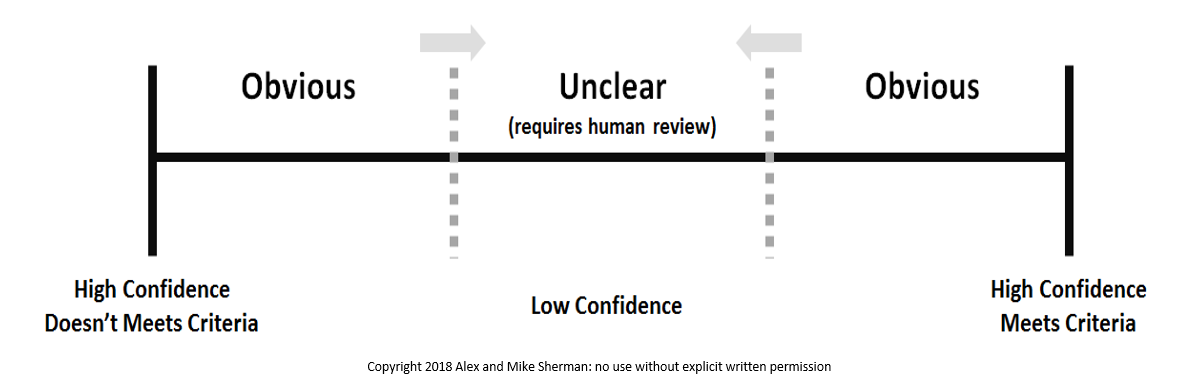

In [128]:
# Log loss use case
Image("../../raw_data/images/log_loss_prediction_confidence.png", width=600)

In [129]:
Image("../../raw_data/images/log_loss_equation.png", width=800)

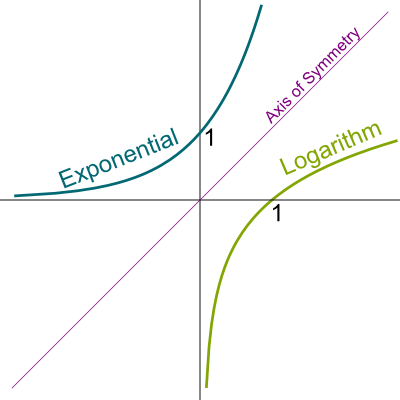

In [130]:
Image("../../raw_data/images/Graph-of-Logarithm-and-Exponential.png", width=300)

In [131]:
from sklearn.metrics import log_loss

y_pred = [
    [[.99, .01], [.99, .01], [.01, .99], [.01, .99]],
    [[.9, .1], [.9, .1], [.1, .9], [.1, .9]],
    [[.8, .2], [.8, .2], [.2, .8], [.2, .8]],
    [[.7, .3], [.7, .3], [.3, .7], [.3, .7]],
    [[.6, .4], [.6, .4], [.4, .6], [.4, .6]],
    [[.5, .5], [.5, .5], [.5, .5], [.5, .5]],
    [[.4, .6], [.4, .6], [.6, .4], [.6, .4]],
    [[.3, .7], [.3, .7], [.7, .3], [.7, .3]],
    [[.2, .8], [.2, .8], [.8, .2], [.8, .2]],
    [[.1, .9], [.1, .9], [.9, .1], [.9, .1]],
    [[.01, .99], [.01, .99], [.99, .01], [.99, .01]],
    [[.001, .999], [.001, .999], [.999, .001], [.999, .001]],
    
    # examples with a single poor prediction
    [[.9, .1], [.1, .9], [.1, .9], [.1, .9]],
    [[.9, .1], [.1, .5], [.1, .9], [.1, .9]],

]
y_true = [0, 0, 1, 1]

for pred in y_pred:
    print(pred)
    print(log_loss(y_true, pred))
    print()

[[0.99, 0.01], [0.99, 0.01], [0.01, 0.99], [0.01, 0.99]]
0.01005033585350145

[[0.9, 0.1], [0.9, 0.1], [0.1, 0.9], [0.1, 0.9]]
0.10536051565782628

[[0.8, 0.2], [0.8, 0.2], [0.2, 0.8], [0.2, 0.8]]
0.2231435513142097

[[0.7, 0.3], [0.7, 0.3], [0.3, 0.7], [0.3, 0.7]]
0.35667494393873245

[[0.6, 0.4], [0.6, 0.4], [0.4, 0.6], [0.4, 0.6]]
0.5108256237659907

[[0.5, 0.5], [0.5, 0.5], [0.5, 0.5], [0.5, 0.5]]
0.6931471805599453

[[0.4, 0.6], [0.4, 0.6], [0.6, 0.4], [0.6, 0.4]]
0.916290731874155

[[0.3, 0.7], [0.3, 0.7], [0.7, 0.3], [0.7, 0.3]]
1.2039728043259361

[[0.2, 0.8], [0.2, 0.8], [0.8, 0.2], [0.8, 0.2]]
1.6094379124341003

[[0.1, 0.9], [0.1, 0.9], [0.9, 0.1], [0.9, 0.1]]
2.3025850929940455

[[0.01, 0.99], [0.01, 0.99], [0.99, 0.01], [0.99, 0.01]]
4.605170185988091

[[0.001, 0.999], [0.001, 0.999], [0.999, 0.001], [0.999, 0.001]]
6.907755278982137

[[0.9, 0.1], [0.1, 0.9], [0.1, 0.9], [0.1, 0.9]]
0.6546666599918811

[[0.9, 0.1], [0.1, 0.5], [0.1, 0.9], [0.1, 0.9]]
0.5269602540503835



### Document Classification

- Identify any section that will discuss fees in the section text, by making a prediction on the section name

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics

In [24]:
# set the labels
df['contains_fee'] = df['section_text'].str.contains('fee')
df['contains_fee'].value_counts()

False    2632
True      178
Name: contains_fee, dtype: int64

In [25]:
# baseline metrics
minority_class = df['contains_fee'].value_counts()[1]
majority_class = df['contains_fee'].value_counts()[0]

majority_class / (majority_class + minority_class)

0.9366548042704627

##### Baseline Metrics

In [26]:
# separate the features and response
X = df['section_name']
y = df['contains_fee']

In [30]:
# develop features from the text data
vect = TfidfVectorizer()
fit_vect = vect.fit_transform(X)

### Sklearn 4-step modeling process

In [36]:
# import model
from sklearn.linear_model import LogisticRegression

# instantiate the model
logreg = LogisticRegression()

# fit the model with data
logreg.fit(fit_vect, y)

# use the model to create predictions
pred_class = logreg.predict(fit_vect)

# evaluate the model
metrics.f1_score(pred_class, y)

### NOTE: this approach is not valid for evaluation as 
#         you cannot train and evaluate a model on the same data

0.1450777202072539

##### Train Test Split

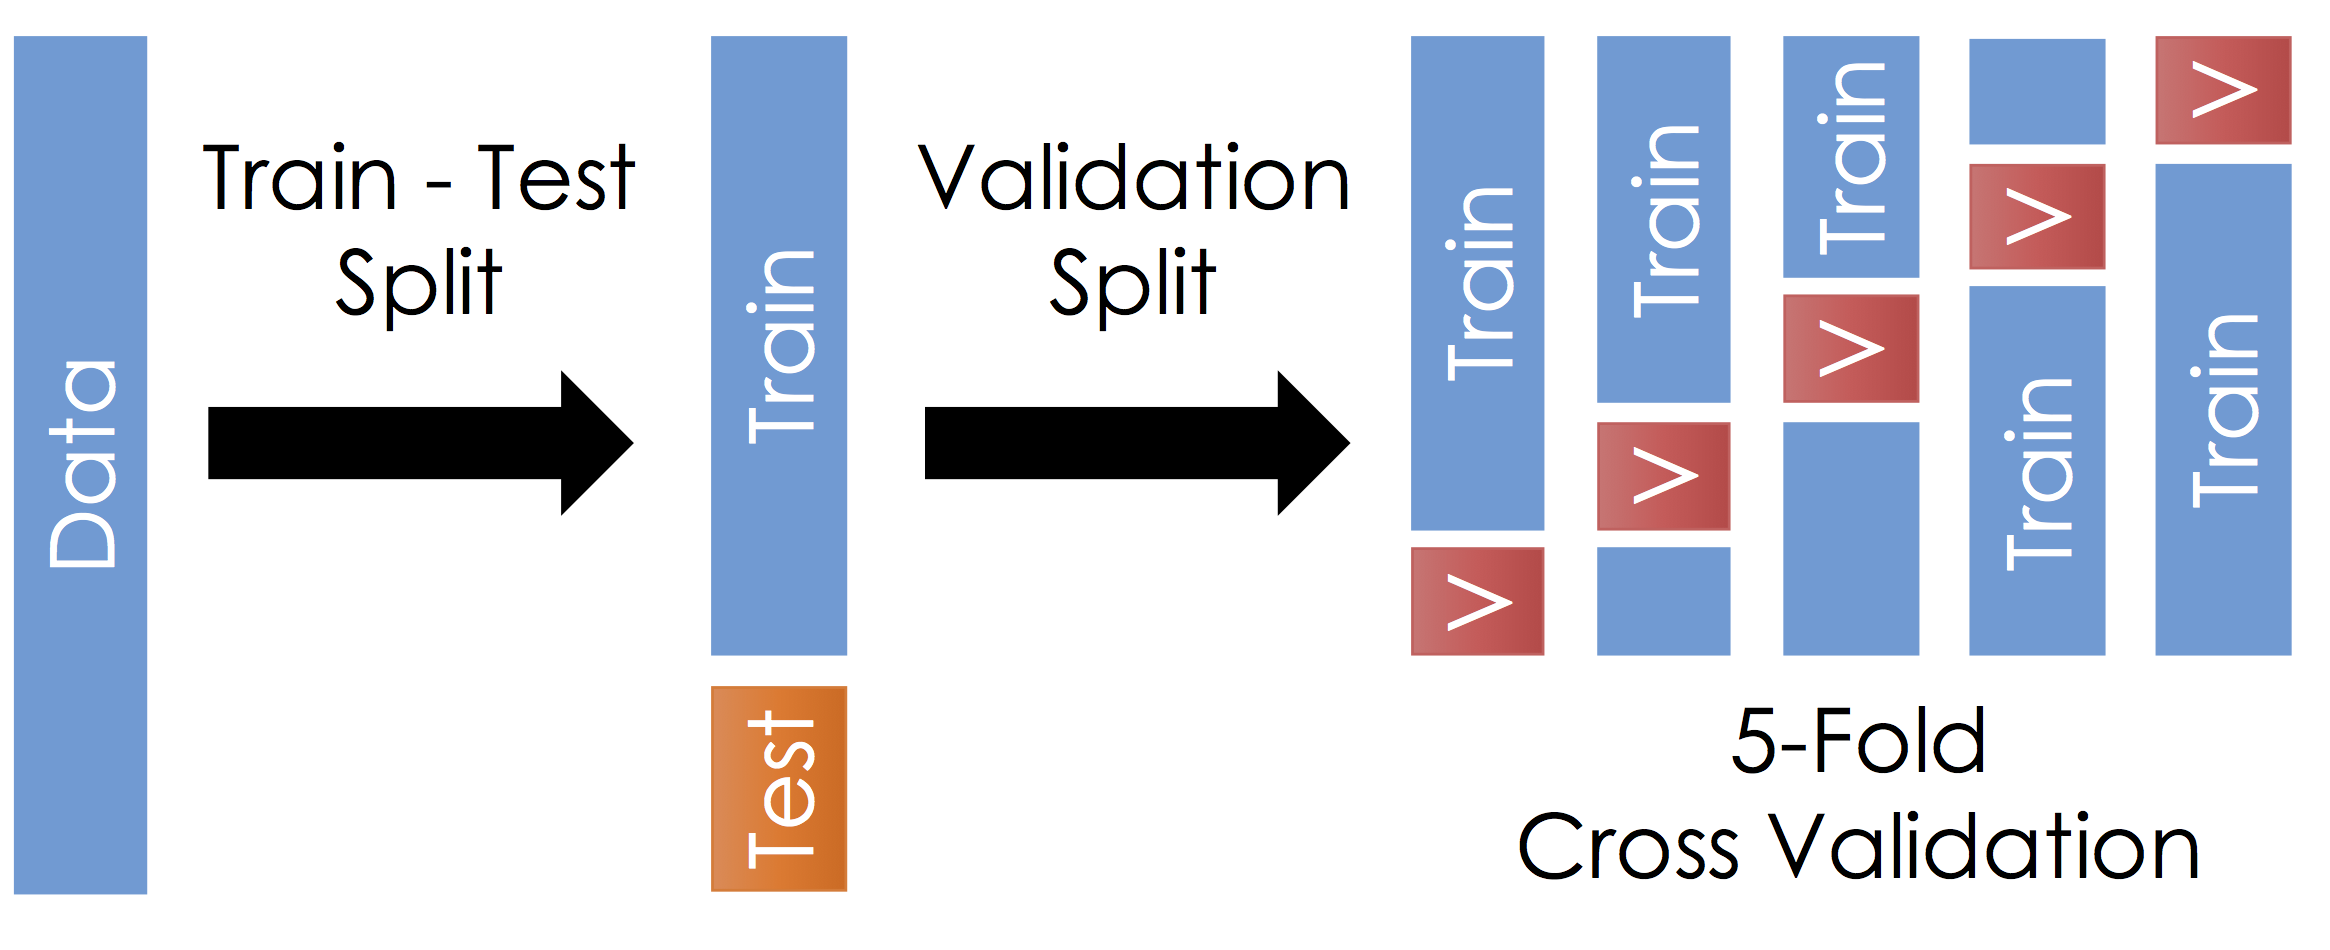

In [138]:
# cross validation
Image("../../raw_data/images/cross_validation.png", width=500)

In [37]:
from sklearn.model_selection import train_test_split

# create train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

# create features
vect = TfidfVectorizer()
train_fit_vect = vect.fit_transform(X_train)

# build and evaluate model using train test split
logreg = LogisticRegression(C=100)
logreg.fit(train_fit_vect, y_train)

# transform testing data for evaluation
test_fit_vect = vect.transform(X_test)
pred_class = logreg.predict(test_fit_vect)

# evaluate a model
print('accuracy: {}'.format(metrics.accuracy_score(pred_class, y_test)))
print('f1: {}'.format(metrics.f1_score(pred_class, y_test)))

accuracy: 0.9459459459459459
f1: 0.5681818181818181


##### NOTE: some metrics can be misleading (e.g. accuracy)

With imbalanced classes, a high accuracy score may mean that every prediction is for the majority class; thus, providing a model that is accurate, but useless!

##### Cross Validation

The performance measure reported by k-fold cross-validation is then the average of the values computed in the loop. This approach can be computationally expensive, but does not waste too much data (as it is the case when fixing an arbitrary test set), which is a major advantage in problem such as inverse inference where the number of samples is very small.

SOURCE: http://scikit-learn.org/stable/modules/cross_validation.html#cross-validation

In [43]:
from sklearn.model_selection import cross_val_score

# instantiate model
# tune the regularization strength
logreg = LogisticRegression(C=100)

# create validation set for final cross val testing
X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=.10, random_state=42)

# develop features from the text data
# using all of X_train is the incorrect approach 
# we will correct in a later class, for now see the note below
vect = TfidfVectorizer()
train_fit_vect = vect.fit_transform(X_train)

# run k-fold cross validation
# stratified cross validation occurs by default for classification
scores = cross_val_score(
      estimator=logreg
    , X=train_fit_vect
    , y=y_train
    , cv=3
    , scoring='f1'
)

# evaluate the results of cross validation for each fold
print('Scores for each of k-fold splits: {}\n'.format(scores))
print('Mean score across all k-fold splits: {} (+/- {})'.format(scores.mean(), scores.std()))

Scores for each of k-fold splits: [0.58252427 0.54761905 0.5       ]

Mean score across all k-fold splits: 0.5433811064879026 (+/- 0.03382340382679948)


In [141]:
logreg.fit(train_fit_vect, y_train)

# use the same learned features to transform the final validation set
fit_vect_validation = vect.transform(X_validation)
validation_pred = logreg.predict(fit_vect_validation)
metrics.f1_score(y_validation, validation_pred)

0.4827586206896552

### IMPORTANT NOTE - Feature Selection in Cross Validation

We are not correctly using cross validation in this notebook as cross validation should also encompass feature selection.

When we ran the TfidfVectorizer, we used the entire dataset. This means that the information from the testing data set leaked into the training. For instance, there are likely words in the testing dataset that never would have been seen and statistics (e.g. get the top 100 most frequent words) use information from text that is later put into the testing data set. 

The correct way to execute TfidfVectorizer is once for every training split. 
- In a **train test split** that means running TfidfVectorizer only on the training set as we did above, then transforming (i.e. using the learned vocabularly from the training set) the testing set.
- In **cross validation**, this is more difficult, as the cross_val_score (or other cross validation object) creates many train test splits, which we do not directly access. Thus, it is harder to ensure that text features are only learned from the training set. This requires us to set up a feature engineering pipeline (often by using the sklearn object PipeLine). We will learn this in a later lesson.

In [142]:
logreg = LogisticRegression(C=100)
scores = cross_val_score(logreg, train_fit_vect, y_train, cv=3, scoring='f1')
print(scores.mean())

0.5433811064879026


##### cross_val_predict
The function cross_val_predict has a similar interface to cross_val_score, but returns, for each element in the input, the prediction that was obtained for that element when it was in the test set. Only cross-validation strategies that assign all elements to a test set exactly once can be used (otherwise, an exception is raised).

In [42]:
from sklearn.model_selection import cross_val_predict

logreg = LogisticRegression(C=100)
predicted = cross_val_predict(logreg, train_fit_vect, y_train, cv=3)
predicted

array([False, False, False, ..., False, False, False])

##### cross_validate

The cross_validate function differs from cross_val_score in two ways -

It allows specifying multiple metrics for evaluation.
It returns a dict containing training scores, fit-times and score-times in addition to the test score.

In [41]:
from sklearn.model_selection import cross_validate

# set evaluation metrics to return from cross validation
scoring = ['f1','accuracy', 'precision', 'recall']

# run cross validation
scores = cross_validate(
      LogisticRegression(C=100)
    , train_fit_vect
    , y_train
    , scoring=scoring
    , cv=3
    , return_train_score=True
)

# review evaluation metrics
scores

{'fit_time': array([0.01249766, 0.01199794, 0.02199936]),
 'score_time': array([0.00650549, 0.00500131, 0.00550056]),
 'test_f1': array([0.51219512, 0.56410256, 0.56756757]),
 'train_f1': array([0.8313253 , 0.87058824, 0.79012346]),
 'test_accuracy': array([0.943101  , 0.95156695, 0.95441595]),
 'train_accuracy': array([0.98005698, 0.98434164, 0.97580071]),
 'test_precision': array([0.55263158, 0.62857143, 0.67741935]),
 'train_precision': array([0.8625    , 0.89156627, 0.85333333]),
 'test_recall': array([0.47727273, 0.51162791, 0.48837209]),
 'train_recall': array([0.80232558, 0.85057471, 0.73563218])}

# Advanced cross validation considerations

##### Cross-validation iterators for grouped data

GroupKFold is a variation of k-fold which ensures that the same group is not represented in both testing and training sets. For example if the data is obtained from different subjects with several samples per-subject and if the model is flexible enough to learn from highly person specific features it could fail to generalize to new subjects. GroupKFold makes it possible to detect this kind of overfitting situations.

Each subject is in a different testing fold, and the same subject is never in both testing and training. Notice that the folds do not have exactly the same size due to the imbalance in the data.

In [145]:
from sklearn.model_selection import GroupKFold

X_ = [0.1, 0.2, 2.2, 2.4, 2.3, 4.55, 5.8, 8.8, 9, 10]
y_ = ["a", "b", "b", "b", "c", "c", "c", "d", "d", "d"]
groups = [1, 1, 1, 2, 2, 2, 3, 3, 3, 3]

gkf = GroupKFold(n_splits=3)
for train, test in gkf.split(X_, y_, groups=groups):
    print("TRAIN:{}   TEST:{}".format(train, test))

TRAIN:[0 1 2 3 4 5]   TEST:[6 7 8 9]
TRAIN:[0 1 2 6 7 8 9]   TEST:[3 4 5]
TRAIN:[3 4 5 6 7 8 9]   TEST:[0 1 2]


##### Cross validation of time series data

Time series data is characterised by the correlation between observations that are near in time (autocorrelation). However, classical cross-validation techniques such as KFold and ShuffleSplit assume the samples are independent and identically distributed, and would result in unreasonable correlation between training and testing instances (yielding poor estimates of generalisation error) on time series data. Therefore, it is very important to evaluate our model for time series data on the “future” observations least like those that are used to train the model. To achieve this, one solution is provided by TimeSeriesSplit.

TimeSeriesSplit is a variation of k-fold which returns first k folds as train set and the (k+1) th fold as test set. Note that unlike standard cross-validation methods, successive training sets are supersets of those that come before them. Also, it adds all surplus data to the first training partition, which is always used to train the model.

This class can be used to cross-validate time series data samples that are observed at fixed time intervals.

##### A Note on Shuffling
If the data ordering is not arbitrary (e.g. samples with the same class label are contiguous), shuffling it first may be essential to get a meaningful cross- validation result. However, the opposite may be true if the samples are not independently and identically distributed. For example, if samples correspond to news articles, and are ordered by their time of publication, then shuffling the data will likely lead to a model that is overfit and an inflated validation score: it will be tested on samples that are artificially similar (close in time) to training samples.

In [146]:
from sklearn.model_selection import TimeSeriesSplit

# Example of 3-split time series cross-validation on a dataset with 6 samples
X_ = np.array([[1, 2], [3, 4], [1, 2], [3, 4], [1, 2], [3, 4]])
y_ = np.array([0, 1, 2, 3, 4, 5])
tscv = TimeSeriesSplit(n_splits=3)
print(tscv)  

for train, test in tscv.split(X_):
    print("{} {}".format(train, test))

TimeSeriesSplit(max_train_size=None, n_splits=3)
[0 1 2] [3]
[0 1 2 3] [4]
[0 1 2 3 4] [5]


### Common mistakes in model evaluation

*__over-fitting at the second level of inference (i.e., model selection) can have a very substantial deleterious effect on the generalisation performance of state-of-the-art machine learning algorithms__*

Some, apparently quite benign, performance evaluation protocols in common use by the machine learning community [e.g. feature selection before model evaluation] are susceptible to this form of bias, and thus potentially give spurious results. In order to avoid this bias, model selection must be treated as an integral part of the model fitting process and performed afresh every time a model is fitted to a new sample of data. Furthermore, as the differences in performance due to model selection are shown to be often of comparable magnitude to the difference in performance between learning algorithms, it seems no longer meaningful to evaluate the performance of machine learning algorithms in isolation, and we should instead compare learning algorithm/model selection procedure combinations. However, this means that robust unbiased performance evaluation is likely to require more rigorous and computationally intensive protocols, such as **nested cross-validation or “double cross”** (Stone, 1974).

##### Bias in performance estimates 
Avoiding potentially significant bias in performance evaluation, arising due to over-fitting in model selection, is conceptually straightforward. The key is to treat both training and model selection together, as integral parts of the model fitting procedure and ensure they are never performed separately at any point of the evaluation process.

##### Biased evaluation methodology 
1. The use of the median, however, can be expected to introduce an optimistic bias into the performance estimates obtained using this “median” protocol. Firstly all of the training data comprising the first five realisations have been used during the model selection process for the classifiers used in every fold of the re-sampling. This means that some of the test data for each fold is no longer statistically “pure” as it has been seen during model selection.

2. More importantly, the median operation acts as a variance reduction step, so the median of the five sets of hyper-parameters is likely to be better on average than any of the five from which it is derived. 

3. As the hyper-parameters are now fixed, there is no longer scope for over-fitting the model selection criterion due to peculiarities of the sampling of data for the training and test partitions in each realisation.

4. In a biased evaluation protocol, occasionally observed in machine learning studies, an initial model selection step is performed using all of the available data, often interactively as part of a “preliminary study”. The data are then repeatedly re-partitioned to form one or more pairs of random, disjoint design and test sets. These are then used for performance evaluation using the same fixed set of hyper-parameter values. **_This practice may seem at first glance to be fairly innocuous, however the test data are no longer statistically pure, as they have been “seen” by the models in tuning the hyperparameters._** This would not present a serious problem were it not for the danger of over-fitting in model selection, which means that in practice the hyper-parameters will inevitably be tuned to an extent in ways that take advantage of the statistical peculiarities of this particular set of data rather than only in ways that favor improved generalisation. As a result the hyper-parameter settings retain a partial “memory” of the data that now form the test partition. We should therefore expect to observe an optimistic bias in the performance estimates obtained in this manner.

##### Nested Cross Validation

As Cawley and Talbot point out in their 2010 paper, since we used the test set to both select the values of the parameter and evaluate the model, we risk optimistically biasing our model evaluations. For this reason, if a test set is used to select model parameters, then we need a different test set to get an unbiased evaluation of that selected model.

One way to overcome this problem is to have nested cross validations. First, an inner cross validation is used to tune the parameters and select the best model. Second, an outer cross validation is used to evaluate the model selected by the inner cross validation.


##### Nested Cross Validation in sklearn
Nested cross-validation (CV) is often used to train a model in which hyperparameters also need to be optimized. Nested CV estimates the generalization error of the underlying model and its (hyper)parameter search. Choosing the parameters that maximize non-nested CV biases the model to the dataset, yielding an overly-optimistic score.

Model selection without nested CV uses the same data to tune model parameters and evaluate model performance. Information may thus “leak” into the model and overfit the data. The magnitude of this effect is primarily dependent on the size of the dataset and the stability of the model. See Cawley and Talbot [1] for an analysis of these issues.

To avoid this problem, nested CV effectively uses a series of train/validation/test set splits. In the inner loop (here executed by GridSearchCV), the score is approximately maximized by fitting a model to each training set, and then directly maximized in selecting (hyper)parameters over the validation set. In the outer loop (here in cross_val_score), generalization error is estimated by averaging test set scores over several dataset splits.

SOURCE:
- [On Over-fitting in Model Selection and Subsequent Selection Bias in
Performance Evaluation](http://jmlr.csail.mit.edu/papers/volume11/cawley10a/cawley10a.pdf)
- [sklearn - nested versus non-nested cross-validation](http://scikit-learn.org/stable/auto_examples/model_selection/plot_nested_cross_validation_iris.html)

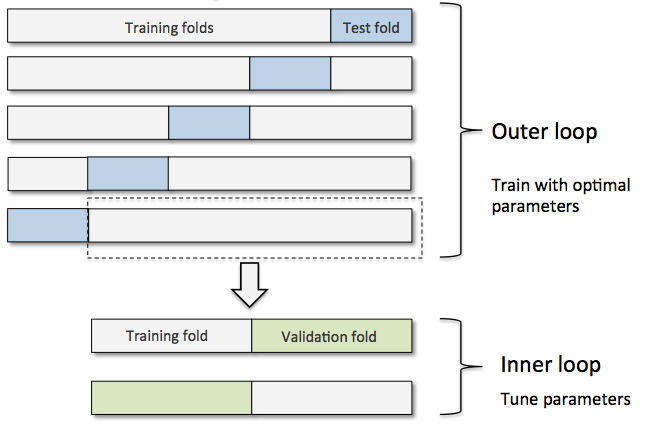

In [147]:
# nested cross validation
Image("../../raw_data/images/nested-k-fold.png", width=350)

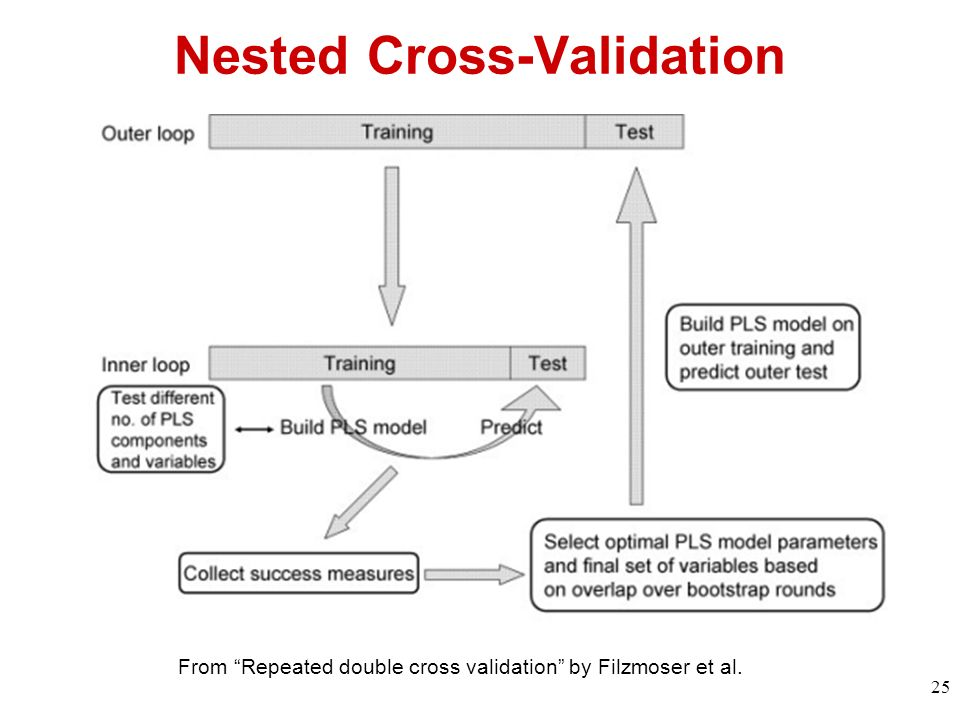

In [148]:
# nested cross validation
Image("../../raw_data/images/nested_cross_validation.jpg", width=350)

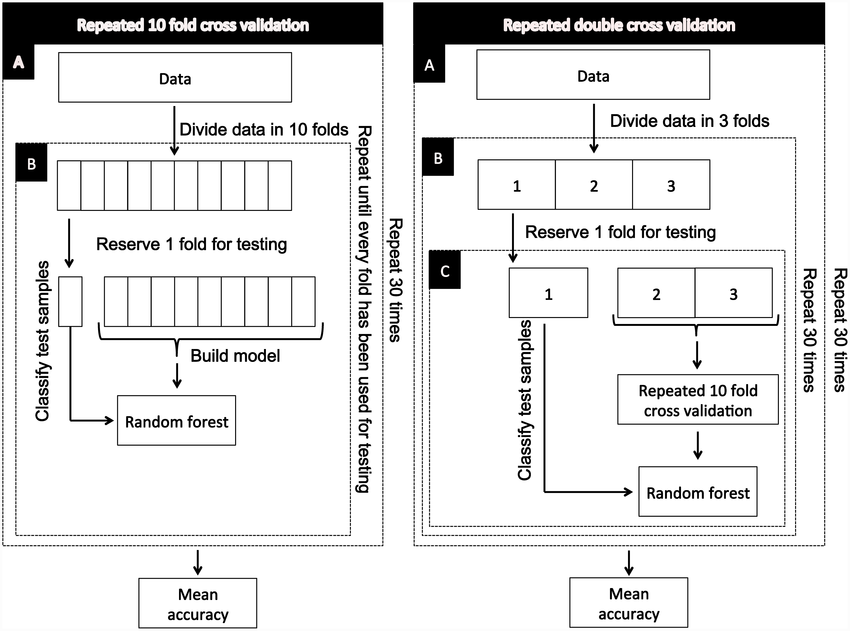

In [149]:
# nested cross validation
Image("../../raw_data/images/The-pipeline-of-the-validation-techniques-known-as-repeated-10-fold-cross-validation-and.png", width=350)

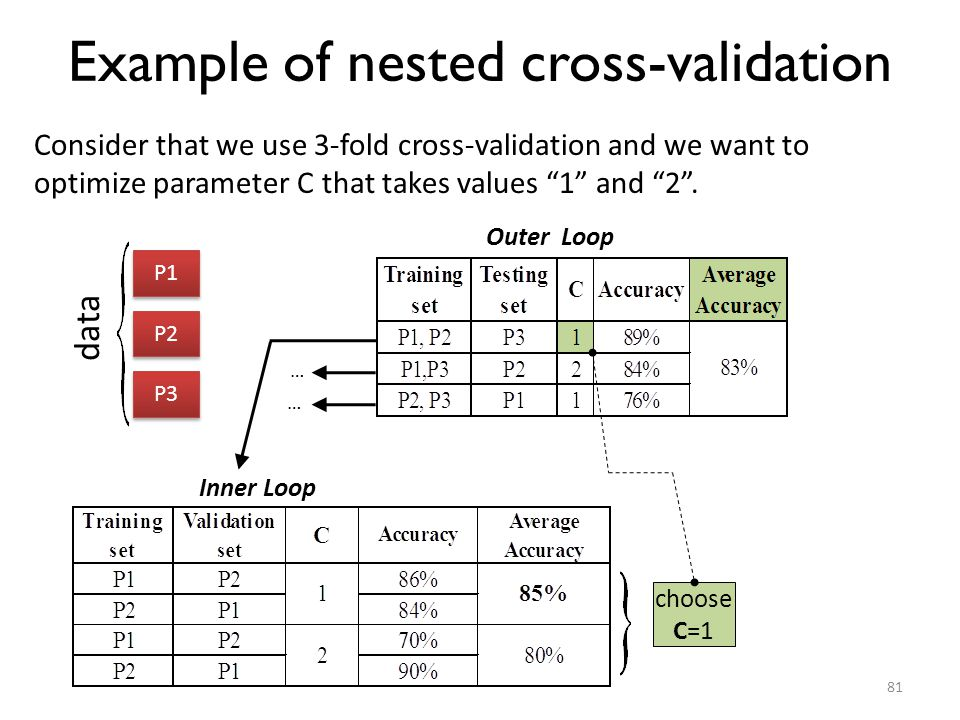

In [150]:
# nested cross validation
Image("../../raw_data/images/double_cross.jpg", width=350)

In [40]:
from sklearn.model_selection import GridSearchCV, KFold

NUM_TRIALS = 10

non_nested_scores = []
nested_scores = []

# We will use a Support Vector Classifier with "rbf" kernel
logreg = LogisticRegression()

# Set up possible values of parameters to optimize over
p_grid = {"C": [1, 10, 100], "penalty": ['l1','l2']}


# Loop for each trial
for i in range(NUM_TRIALS):

    # Non_nested parameter search and scoring
    inner_cv = KFold(n_splits=3, shuffle=True, random_state=i)
    clf = GridSearchCV(estimator=logreg, param_grid=p_grid, cv=inner_cv)
    clf.fit(fit_vect,y)
    non_nested_scores.append(clf.best_score_)

    # Nested CV with parameter optimization
    outer_cv = KFold(n_splits=3, shuffle=True, random_state=i)
    inner_cv = KFold(n_splits=3, shuffle=True, random_state=i)
    clf = GridSearchCV(estimator=logreg, param_grid=p_grid, cv=inner_cv)
    nested_score = cross_val_score(clf, X=fit_vect, y=y, cv=outer_cv)
    nested_scores.append(nested_score.mean())

NameError: name 'cross_val_score' is not defined

In [164]:
print(non_nested_scores)

[0.9533807829181494, 0.9565836298932384, 0.9519572953736655, 0.9558718861209965, 0.9562277580071175, 0.9530249110320285, 0.9530249110320285, 0.9462633451957295, 0.9548042704626335, 0.9548042704626335]


In [163]:
print(nested_scores)

[0.9537367697719886, 0.9558723816994895, 0.9516026781234892, 0.9530252791992386, 0.9558761823969935, 0.9523156889752408, 0.9516000176352364, 0.9459077129834869, 0.9537352494929868, 0.9540932751978644]


# Classification Models

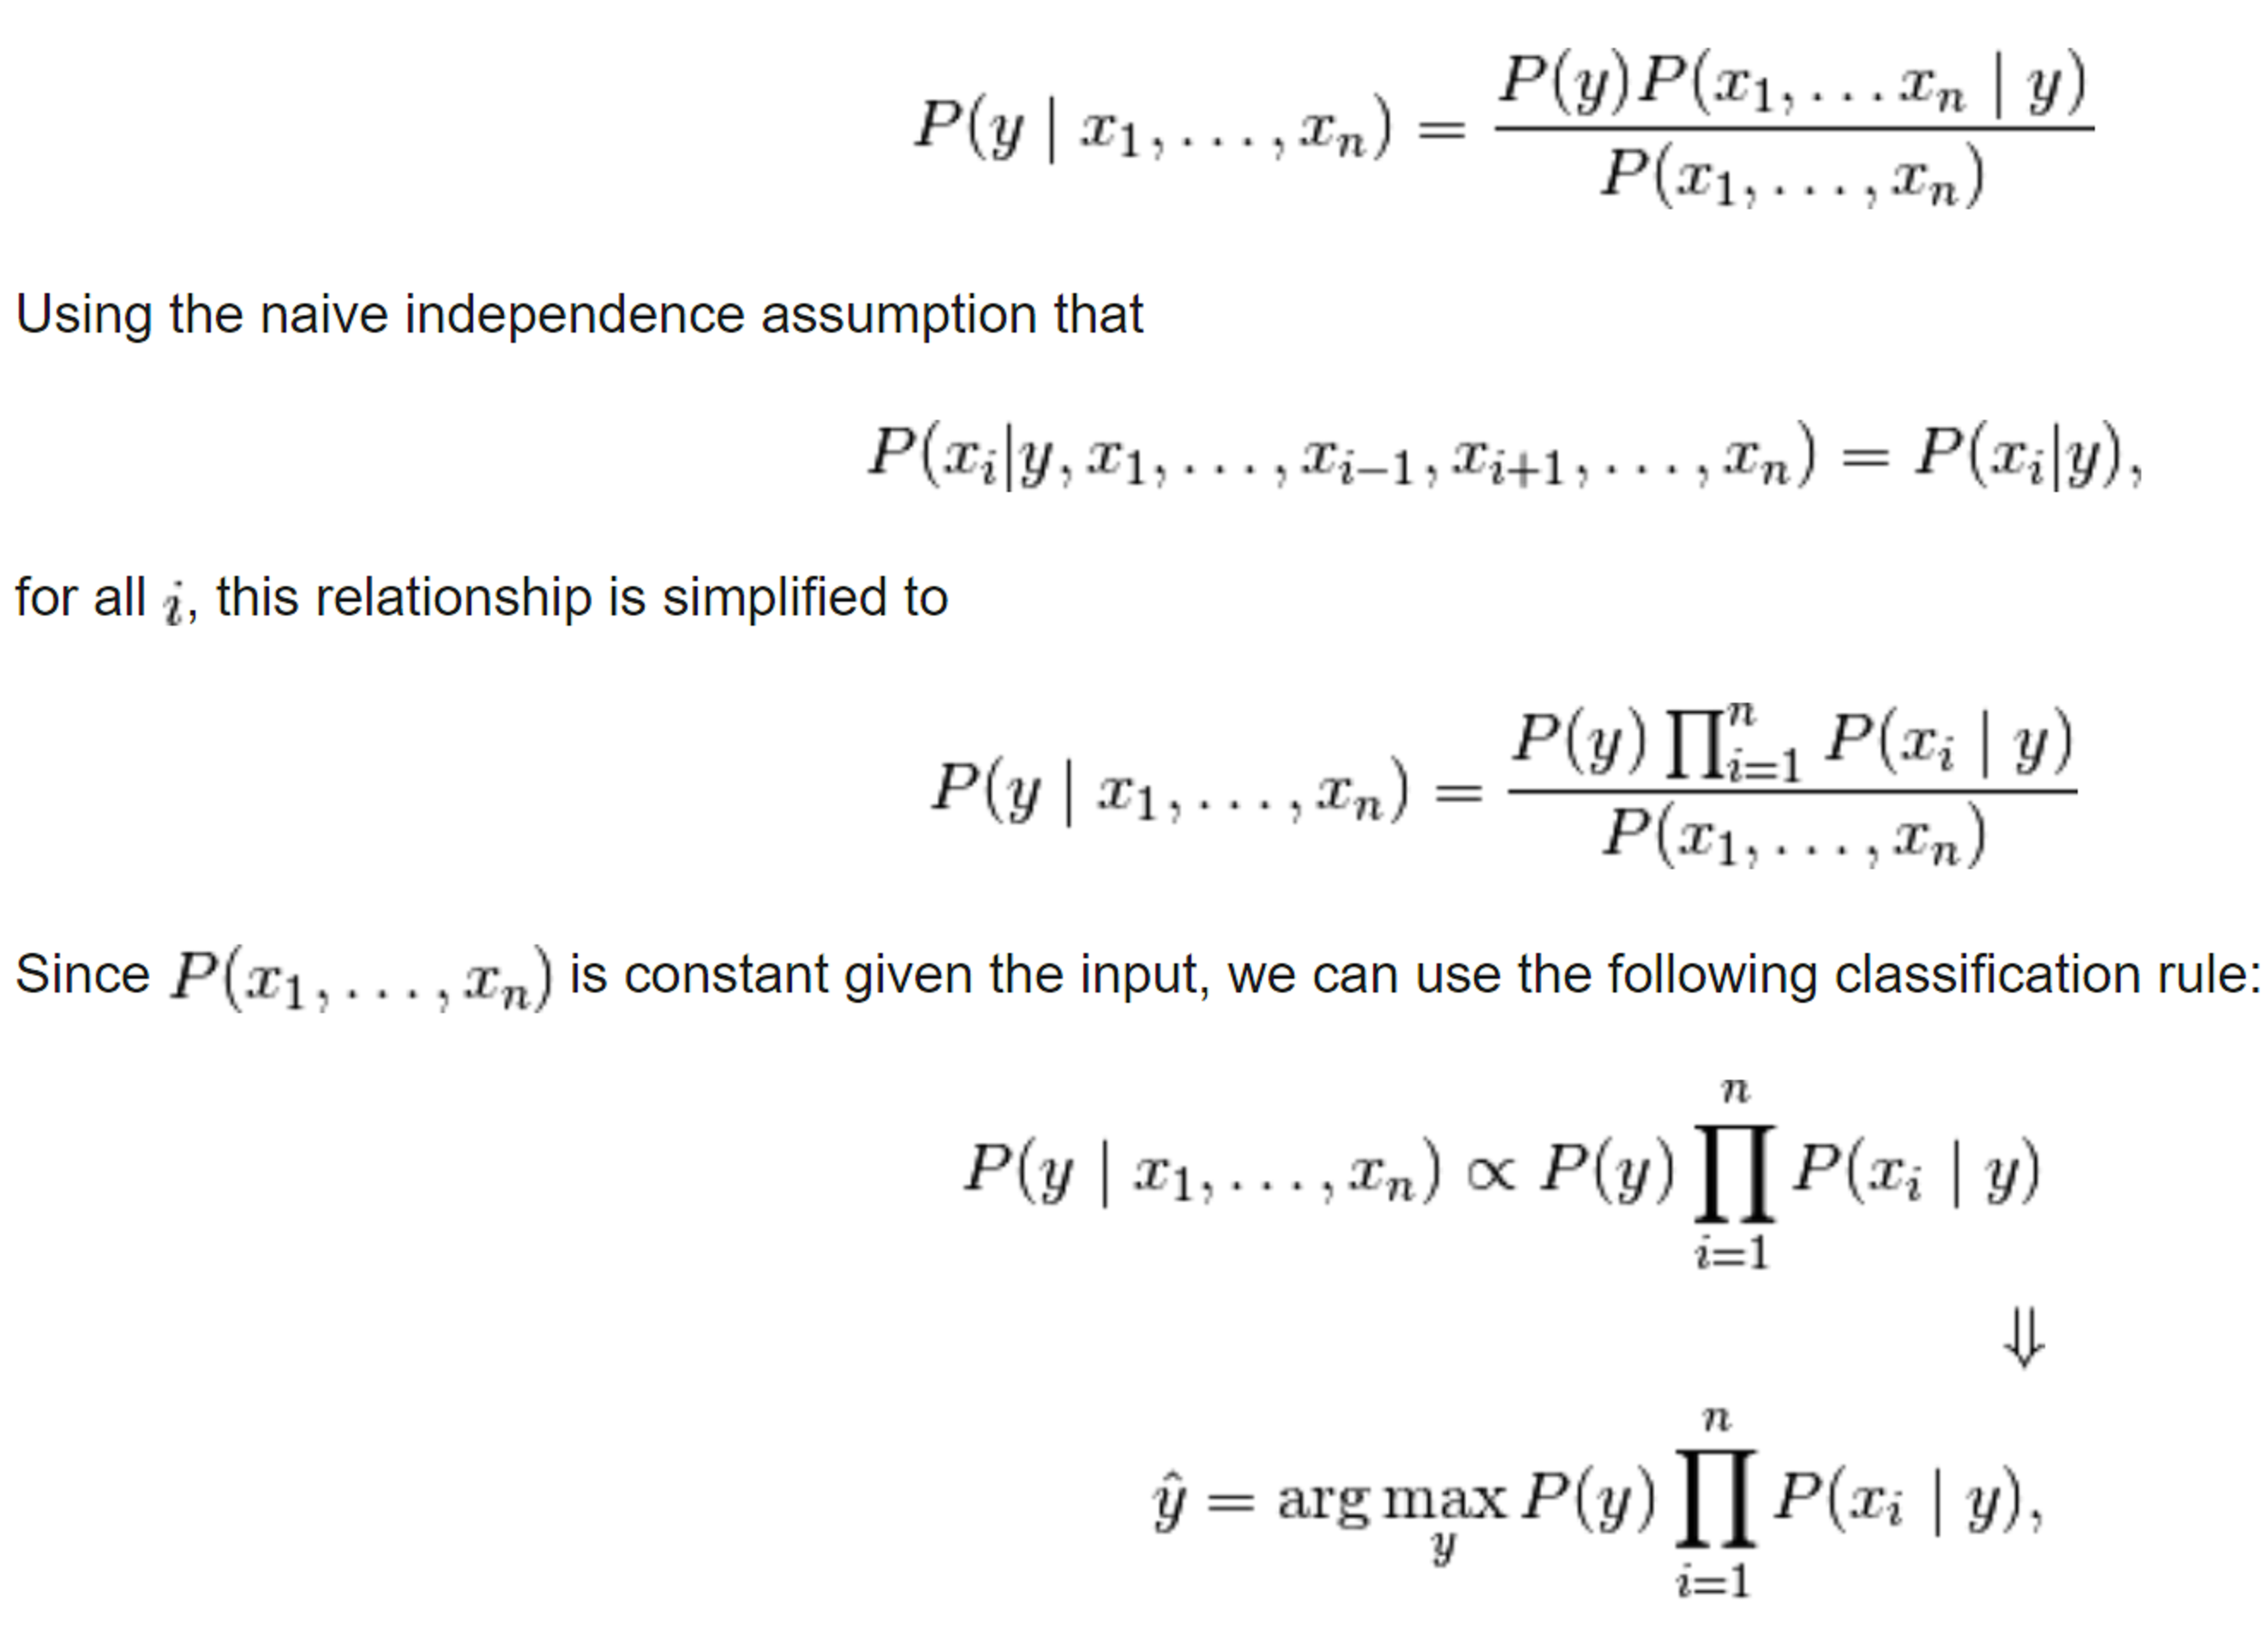

In [165]:
# Naive Bayes Equation
Image("../../raw_data/images/naive_bayes_equation.png", width=600)

In [44]:
from sklearn.naive_bayes import MultinomialNB
nb = MultinomialNB()
scores = cross_val_score(nb, train_fit_vect, y_train, cv=3, scoring='f1')
print(scores.mean())

0.012121212121212121


##### Ensemble Methods

The goal of ensemble methods is to combine the predictions of several base estimators built with a given learning algorithm in order to improve generalizability / robustness over a single estimator.

Two families of ensemble methods are usually distinguished:
1. In **averaging methods**, the driving principle is to build several estimators independently and then to average their predictions. On average, the combined estimator is usually better than any of the single base estimator because its variance is reduced (Examples: Bagging methods, Forests of randomized trees, ...)

2. By contrast, in **boosting methods**, base estimators are built sequentially and one tries to reduce the bias of the combined estimator. The motivation is to combine several weak models to produce a powerful ensemble (Examples: AdaBoost, Gradient Tree Boosting, ...)

SOURCE:
- [sklearn documentation: Ensemble Methods](http://scikit-learn.org/stable/modules/ensemble.html#forest)

In [45]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=1000)
scores = cross_val_score(rf, train_fit_vect, y_train, cv=3, scoring='f1')
print(scores.mean())


1  T
2  F
3  F

1 .33  .2
2 .33  .4
3 .33  .4

0.5333128520225294


##### AdaBoost

The core principle of AdaBoost is to fit a sequence of weak learners (i.e., models that are only slightly better than random guessing, such as small decision trees) on repeatedly modified versions of the data. The predictions from all of them are then combined through a weighted majority vote (or sum) to produce the final prediction. 

The data modifications at each so-called boosting iteration consist of applying weights w_1, w_2, …, w_N to each of the training samples. Initially, those weights are all set to w_i = 1/N, so that the first step simply trains a weak learner on the original data. For each successive iteration, the sample weights are individually modified and the learning algorithm is reapplied to the reweighted data. 

At a given step, those training examples that were incorrectly predicted by the boosted model induced at the previous step have their weights increased, whereas the weights are decreased for those that were predicted correctly. As iterations proceed, examples that are difficult to predict receive ever-increasing influence. Each subsequent weak learner is thereby forced to concentrate on the examples that are missed by the previous ones in the sequence.

In [168]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier(n_estimators=1000)
scores = cross_val_score(ada, train_fit_vect, y_train, cv=3, scoring='f1')
print(scores.mean())

0.5586559990872659


##### K Nearest Neighbors (KNN)

Neighbors-based classification is a type of instance-based learning or non-generalizing learning: it does not attempt to construct a general internal model, but simply stores instances of the training data. Classification is computed from a simple majority vote of the nearest neighbors of each point: a query point is assigned the data class which has the most representatives within the nearest neighbors of the point.

scikit-learn implements two different nearest neighbors classifiers: KNeighborsClassifier implements learning based on the k nearest neighbors of each query point, where k is an integer value specified by the user. RadiusNeighborsClassifier implements learning based on the number of neighbors within a fixed radius r of each training point, where r is a floating-point value specified by the user.

SOURCE: [Nearest Neighbors Classification](http://scikit-learn.org/stable/modules/neighbors.html#classification)

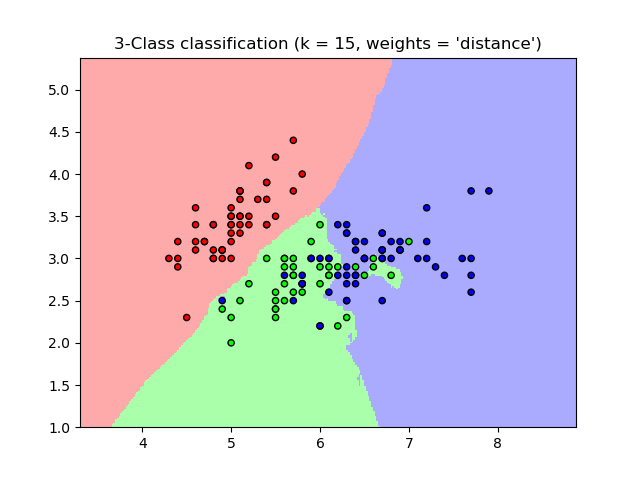

In [169]:
# nested cross validation
Image("../../raw_data/images/knn_plot.png", width=400)

In [170]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=3)
scores = cross_val_score(knn, train_fit_vect, y_train, cv=3, scoring='f1')
print(scores.mean())  

0.5257487610428787


##### Logistic Regression

In [171]:
from sklearn.linear_model import LogisticRegression

logreg = LogisticRegression()
scores = cross_val_score(logreg, train_fit_vect, y_train, cv=3, scoring='f1')
print(scores.mean())  

0.0


C:\Users\alsherman\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\alsherman\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\alsherman\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


##### SGD Classifier

In [46]:
from sklearn.linear_model import SGDClassifier

sgd = SGDClassifier()
scores = cross_val_score(sgd, train_fit_vect, y_train, cv=3, scoring='f1')
print(scores.mean())  

0.5141966857762187


C:\Users\alsherman\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)
C:\Users\alsherman\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % typ

##### Ridge Classifier

In [175]:
from sklearn.linear_model import RidgeClassifier

ridge = RidgeClassifier(alpha=.001, class_weight={0:.5,1:.5})
scores = cross_val_score(ridge, train_fit_vect, y_train, cv=3, scoring='f1')
print(scores.mean())  

0.5457828566426817


##### Multi-layer Perceptron classifier

In [47]:
from sklearn.neural_network import MLPClassifier

clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(100,100), random_state=42)
scores = cross_val_score(clf, train_fit_vect, y_train, cv=3, scoring='f1')
print(scores.mean())                       

0.5822710622710623


### Scaling with instances using out-of-core learning

Out-of-core (or “external memory”) learning is a technique used to learn from data that cannot fit in a computer’s main memory (RAM).

Here is sketch of a system designed to achieve this goal:
1. a way to stream instances
2. a way to extract features from instances
3. an incremental algorithm


##### Out of Core learning with Partial Fit
The problem with standard (usually gradient-descent-based) regression/classification implementations, support vector machines (SVMs), random forests etc is that they do not effectively scale to the data size we are talking, because of the need to load all the data into memory at once and/or nonlinear computation time. SGD, however, can deal with large data sets effectively by breaking up the data into chunks and processing them sequentially, as we will see shortly; this is often called minibatch learning. The fact that we only need to load one chunk into memory at a time makes it useful for large-scale data, and the fact that it can work iteratively allows it to be used for online learning as well. SGD can be used for regression or classification with any regularization scheme (ridge, lasso, etc) and any loss function (squared loss, logistic loss, etc).

The key feature of sklearn’s SGDRegressor and SGDClassifier classes that we’re interested in is the partial_fit() method; this is what supports minibatch learning. Whereas other estimators need to receive the entire training data in one go, there is no such necessity with the SGD estimators. One can, for instance, break up a data set of a million rows into a thousand chunks, then successively execute partial_fit() on each chunk. Each time one chunk is complete, it can be thrown out of memory and the next one loaded in, so memory needs are limited to the size of one chunk, not the entire data set.

SOURCE: 
- [Strategies to scale computationally: bigger data](http://scikit-learn.org/stable/modules/scaling_strategies.html)
- [Minibatch learning for large-scale data, using scikit-learn](https://adventuresindatascience.wordpress.com/2014/12/30/minibatch-learning-for-large-scale-data-using-scikit-learn/)

In [178]:
from sklearn.linear_model import SGDClassifier
from collections import Counter

sgd_clf = SGDClassifier(max_iter=5, tol=None)

start_ind = 0
for end_ind in range(1, train_fit_vect.shape[0], 100):
    partial_vect = train_fit_vect[start_ind:end_ind]
    partial_y = y_train[start_ind:end_ind]
    sgd_clf.partial_fit(partial_vect, partial_y, classes=[True, False])
    # reset index
    start_ind = end_ind
    
predicted = sgd_clf.predict(fit_vect_validation)

print(Counter(predicted))
print(metrics.f1_score(y_validation, predicted))

Counter({False: 267, True: 14})
0.5161290322580646


# Data Engineering

## Model Considerations for Production

### Prediction Latency

The main factors that influence the prediction latency are
1. Number of features
2. Input data representation and sparsity
3. Model complexity
4. Feature extraction

SOURCE: http://scikit-learn.org/stable/modules/computational_performance.html

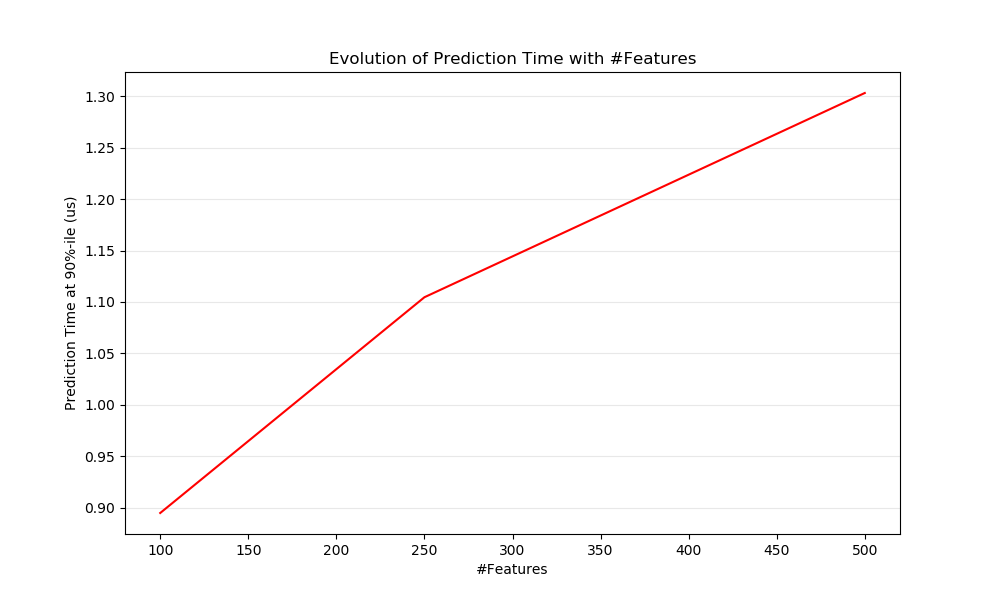

In [160]:
# latency increases as the number of features increases
Image("../../raw_data/images/prediction_latency.png", width=400)

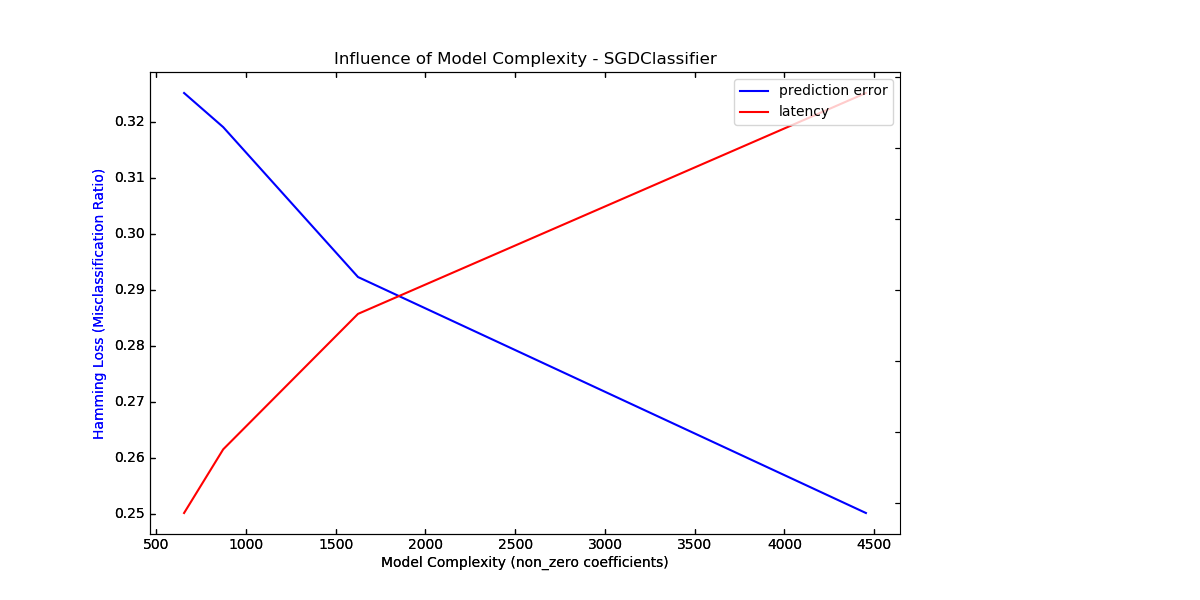

In [152]:
# latency increases as model complexity increases
Image("../../raw_data/images/model_complexity_influence.png", width=400)